In [15]:
import plotly.graph_objects as go
import models
import diagnostics
import os
import preprocess
import plots
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

### Setup

In [16]:
file_path = os.getenv("FILE_PATH")
NASDAQ_file = './data/NASDAQ Composite Index.csv'

In [17]:
# Scale is applied to log returns in order to improve numerical stability of models
SCALE = 1

### S&P500 Log Returns

In [18]:
NASDAQ_processed = preprocess.preprocess_data(NASDAQ_file, 'price', 'log_returns')
NASDAQ_processed['log_returns'] = NASDAQ_processed['log_returns'] * SCALE

In [19]:
nasdaq_obj = utils.SnpDf(NASDAQ_processed)
nasdaq_fbm = utils.apply_rolling_predictions_from_start(nasdaq_obj, '2017-01-01', 250)

# Compute log returns
nasdaq_fbm["predicted_log_returns"] = np.log(nasdaq_fbm["predicted"] / nasdaq_fbm["predicted"].shift(1))
nasdaq_fbm = nasdaq_fbm.dropna()
nasdaq_fbm = nasdaq_fbm.join(NASDAQ_processed, how='inner')

Day 252...
Day 253...
Day 254...
Day 255...
Day 256...
Day 257...
Day 258...
Day 259...
Day 260...
Day 261...
Day 262...
Day 263...
Day 264...
Day 265...
Day 266...
Day 267...
Day 268...
Day 269...
Day 270...
Day 271...
Day 272...
Day 273...
Day 274...
Day 275...
Day 276...
Day 277...
Day 278...
Day 279...
Day 280...
Day 281...
Day 282...
Day 283...
Day 284...
Day 285...
Day 286...
Day 287...
Day 288...
Day 289...
Day 290...
Day 291...
Day 292...
Day 293...
Day 294...
Day 295...
Day 296...
Day 297...
Day 298...
Day 299...
Day 300...
Day 301...
Day 302...
Day 303...
Day 304...
Day 305...
Day 306...
Day 307...
Day 308...
Day 309...
Day 310...
Day 311...
Day 312...
Day 313...
Day 314...
Day 315...
Day 316...
Day 317...
Day 318...
Day 319...
Day 320...
Day 321...
Day 322...
Day 323...
Day 324...
Day 325...
Day 326...
Day 327...
Day 328...
Day 329...
Day 330...
Day 331...
Day 332...
Day 333...
Day 334...
Day 335...
Day 336...
Day 337...
Day 338...
Day 339...
Day 340...
Day 341...
Day 342...

In [20]:
nasdaq_fbm.head()

,predicted,conditional_vol,predicted_log_returns,price,log_returns
2016-01-06,4894.268150,0.010608,-0.001607,4835.77,-0.011444
2016-01-07,4837.406221,0.010624,-0.011686,4689.43,-0.030729
2016-01-08,4690.042455,0.010789,-0.030937,4643.63,-0.009815
2016-01-11,4642.822550,0.010807,-0.010119,4637.99,-0.001215
2016-01-12,4638.942334,0.010803,-0.000836,4685.92,0.010281


In [21]:
# Rescale back conditional volatility
nasdaq_fbm_rescaled = utils.rescale_columns(
  nasdaq_fbm,
  ['conditional_vol', 'log_returns', 'predicted_log_returns'],
  SCALE
)
diagnostics.in_sample_diagnostics(nasdaq_fbm_rescaled['predicted_log_returns'], nasdaq_fbm_rescaled['log_returns'], nasdaq_fbm_rescaled['conditional_vol'])

Jarque-Bera test p-value: 0.00000
Ljung-Box (residuals) p-value, 0.00000
Ljung-Box (residuals^2) p-value, 0.00000


In [22]:
nasdaq_fbm_var = nasdaq_fbm_rescaled
nasdaq_fbm_var['VaR_99'] = nasdaq_fbm_var['predicted_log_returns'].rolling(250).quantile(0.01)    # 1st percentile
diagnostics.compute_var_violations(nasdaq_fbm_var, 'VaR_99', 'predicted_log_returns')

{'actual_exceedances': 31,
 'expected_exceedances': 20.130000000000017,
 'violation_ratio': 1.5399900645802271}

In [23]:
utils.compute_rmse(nasdaq_fbm_rescaled, 'log_returns', 'predicted_log_returns')

0.020700427077599927

In [24]:
diagnostics.bernoulli_coverage_test(nasdaq_fbm_var, var_col='VaR_99', predicted_col='predicted_log_returns')

(0.024071023518224655, 5.089507730515379)

In [25]:
diagnostics.compute_hit_rate(predicted=nasdaq_fbm_var['predicted_log_returns'], actual=nasdaq_fbm_var['log_returns'])


Hit Rate: 49.47%


0.4946949602122016

### Plots

In [26]:
plots.plot_var_violations(nasdaq_fbm_var, var_col='VaR_99', predicted_col='predicted_log_returns')

In [27]:
from hurst import compute_Hc
import plotly.graph_objects as go

def compute_rolling_hurst(df, window, col='log_returns', lag=0):
    hurst_values = []
    times = []
    
    # Loop through the DataFrame using the rolling window
    for i in range(window - 1, len(df), lag+1):

        # Extract the window slice from the series
        window_series = df[col].iloc[i - window + 1 : i + 1: lag+1]
        
        # Compute the Hurst exponent using the 'change' method and simplified calculation
        h, c, data = compute_Hc(window_series, kind='change', simplified=True)
        
        hurst_values.append(h)
        times.append(df.index[i])
    
    # Create and return a new DataFrame with the computed Hurst exponents
    result_df = pd.DataFrame({'hurst': hurst_values}, index=times)
    return result_df

hurst_window250_lag0 = compute_rolling_hurst(nasdaq_fbm_var, window=250, col='log_returns', lag=0)
hurst_window350_lag0 = compute_rolling_hurst(nasdaq_fbm_var, window=350, col='log_returns', lag=0)
hurst_window500_lag0 = compute_rolling_hurst(nasdaq_fbm_var, window=500, col='log_returns', lag=0)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=hurst_window250_lag0.index,
    y=hurst_window250_lag0["hurst"],
    mode='lines',
    name='250 days rolling window',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=hurst_window350_lag0.index,
    y=hurst_window350_lag0["hurst"],
    mode='lines',
    name='350 days rolling window',
    line=dict(color='red')
))
fig.add_trace(go.Scatter(
    x=hurst_window500_lag0.index,
    y=hurst_window500_lag0["hurst"],
    mode='lines',
    name='500 days rolling window',
    line=dict(color='green')
))
fig.update_layout(
    title=f"Hurst exponent for SNP",
    xaxis_title="Date",
    yaxis_title="Hurst Value",
    template="plotly_white"
)

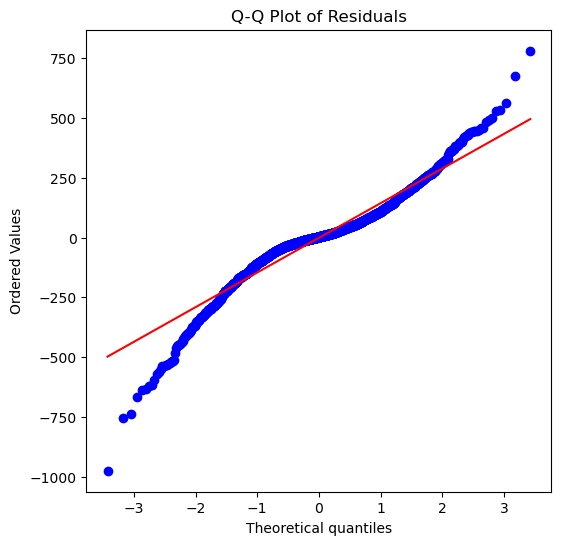

In [29]:
# Q-Q Plot for normality check of the residuals
nasdaq_fbm['residual'] = nasdaq_fbm['price'] - nasdaq_fbm['predicted']

plt.figure(figsize=(6, 6))
stats.probplot(nasdaq_fbm['residual'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()
